In [1]:
import os
from glob import glob
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import numpy as np

In [2]:
data_path = "/userhome/student/bial/neural-punctuator/models/"
model_names = ["hubert", "bert-base-multilingual-cased", "bert-base-multilingual-uncased"]

In [3]:
files = {}
for model_name in model_names:
    f = sorted(glob(data_path + f"{model_name}-unfreezed-epoch*.*"), key=os.path.getmtime)
    files[model_name] = f
files

{'hubert': ['/userhome/student/bial/neural-punctuator/models/hubert-unfreezed-epoch-1.pth',
  '/userhome/student/bial/neural-punctuator/models/hubert-unfreezed-epoch-2.pth',
  '/userhome/student/bial/neural-punctuator/models/hubert-unfreezed-epoch-3.pth',
  '/userhome/student/bial/neural-punctuator/models/hubert-unfreezed-epoch-4.pth',
  '/userhome/student/bial/neural-punctuator/models/hubert-unfreezed-epoch-5.pth',
  '/userhome/student/bial/neural-punctuator/models/hubert-unfreezed-epoch-6.pth',
  '/userhome/student/bial/neural-punctuator/models/hubert-unfreezed-epoch-7.pth',
  '/userhome/student/bial/neural-punctuator/models/hubert-unfreezed-epoch-8.pth',
  '/userhome/student/bial/neural-punctuator/models/hubert-unfreezed-epoch-9.pth',
  '/userhome/student/bial/neural-punctuator/models/hubert-unfreezed-epoch-10.pth',
  '/userhome/student/bial/neural-punctuator/models/hubert-unfreezed-epoch-11.pth',
  '/userhome/student/bial/neural-punctuator/models/hubert-unfreezed-epoch-12.pth'],
 '

In [4]:
def load_scores(model_path, map_location='cpu'):
    checkpoint = torch.load(model_path, map_location=map_location)
    return checkpoint['metrics']

def get_strict_f_score(report):
    return sum(float(report['cls_report'][output]['f1-score']) for output in ('period', 'question', 'comma')) / 3
    
# metrics = {}
# for model_name in model_names:
#     m = []
#     for file in tqdm(files[model_name]):
#         m.append(load_scores(file))
#     metrics[model_name] = m
    
# with open('reports/metrics_hun.pkl', 'wb') as f:
#     pickle.dump(metrics, f)
    
with open('reports/metrics_hun.pkl', 'rb') as f:
    metrics = pickle.load(f)
    
for _, m in metrics.items():
    for epoch in m:
        epoch['strict_f_score'] = get_strict_f_score(epoch)
        
def best_epoch_by_f_score(metrics):
    best_score = metrics[0]['strict_f_score']
    best_epoch = 0
    for i, m in enumerate(metrics):
        if m['strict_f_score'] > best_score:
            best_score = m['strict_f_score']
            best_epoch = i
    return best_epoch, best_score

def best_epoch_by_loss(metrics):
    best_loss = metrics[0]['loss']
    best_epoch = 0
    for i, m in enumerate(metrics):
        if m['loss'] < best_loss:
            best_loss = m['loss']
            best_epoch = i
    return best_epoch, best_loss

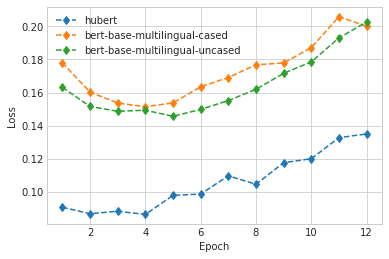

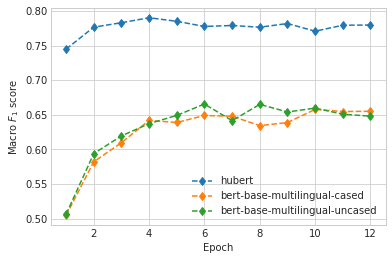

In [5]:
plt.style.use('seaborn-whitegrid')
# plt.title('Valid loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
for model_name, m in metrics.items():
    loss = [float(epoch['loss']) for epoch in m ]
    plt.plot(np.arange(len(loss))+1, loss, '--d')
plt.legend(model_names)
plt.savefig('imgs/valid_loss_hun.pdf')
plt.show()

plt.style.use('seaborn-whitegrid')
# plt.title('Valid F1-score')
plt.ylabel('Macro $F_1$ score')
plt.xlabel('Epoch')
for model_name, m in metrics.items():
    f_score = [float(epoch['strict_f_score']) for epoch in m ]
    plt.plot(np.arange(len(loss))+1, f_score, '--d')
plt.legend(model_names)
plt.savefig('imgs/valid_f1_score_hun.pdf')
plt.show()

In [6]:
from neural_punctuator.utils.data import get_config_from_yaml
from neural_punctuator.models.BertPunctuator import BertPunctuator

import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from neural_punctuator.data.dataloader import BertDataset, collate, get_data_loaders, get_datasets
from neural_punctuator.models.BertPunctuator import BertPunctuator
from torch.optim import AdamW
from torch import nn

from neural_punctuator.utils.io import save, load
from neural_punctuator.utils.metrics import get_total_grad_norm, get_eval_metrics
import numpy as np
import pickle

from torch.utils.data import Dataset, DataLoader
from itertools import product

In [7]:
def combine(pred_num, preds):
    step_num = 512 // pred_num
    multi_preds = [preds[i::pred_num].reshape(-1, preds.shape[-1]) for i in range(pred_num)]
    for i in range(pred_num):
        start_idx = (pred_num - i - 1) * step_num
        end_idx = start_idx + (preds.shape[0] - (pred_num-1)*2) * step_num
        multi_preds[i] = multi_preds[i][start_idx:end_idx]

    multi_preds = np.stack(multi_preds)
    multi_preds = np.log(np.exp(multi_preds).mean(0))
    return multi_preds

def evaluate_multiple_predictions(model_name, model_type, predict_step, device, dataset_type):
    print(model_name, model_type)

    if model_type == 'by_f_score':
        epoch, _ = best_epoch_by_f_score(metrics[model_name])
    elif model_type == 'by_loss':
        epoch, _ = best_epoch_by_loss(metrics[model_name])
    else:
        raise ValueError("Model type not valid, options: by_f_score/by_loss")

    config = get_config_from_yaml(f'neural_punctuator/configs/config-szeged-{model_name}-unfreeze.yaml')
    config.trainer.load_model = f"{model_name}-unfreezed-epoch-{epoch + 1}.pth"

    config.model.predict_step = predict_step
    config.predict.batch_size = 128
    

    model = BertPunctuator(config)
    model.to(device)

    load(model, None, config)

    test_dataset = BertDataset(dataset_type, config)

    test_loader = DataLoader(test_dataset, batch_size=config.predict.batch_size, collate_fn=collate)

    model.eval()
    all_test_preds = []

    for data in tqdm(test_loader):
        text, targets = data
        with torch.no_grad():
            preds, _ = model(text.to(device))

        all_test_preds.append(preds.detach().cpu().numpy())

    all_test_target = test_dataset.targets[512:-512]
    all_test_preds = np.concatenate(all_test_preds)
    pred_num = config.model.seq_len // config.model.predict_step

    ps = combine(pred_num, all_test_preds)
    _targets = np.array(all_test_target[:ps.shape[0]])

    ps = ps[_targets != -1]
    _targets = _targets[_targets != -1]

    report = get_eval_metrics(_targets, ps, config)
    return report

In [8]:
class BertDataset(Dataset):
    def __init__(self, prefix, config, is_train=False):

        self.config = config
        self.is_train = is_train

        with open(self.config.data.data_path + prefix + "_data.pkl", 'rb') as f:
            texts, targets = pickle.load(f)
            self.encoded_texts = 512 * [0] + [word for t in texts for word in t] + 512 * [0]  # Add padding to both ends
            self.targets = 512 * [-1] + [t for ts in targets for t in ts] + 512 * [-1]

    def __getitem__(self, idx):
        if idx == 164:
            pass
        start_idx = (1+idx) * self.config.model.predict_step
        end_idx = start_idx + self.config.model.seq_len
        return torch.LongTensor(self.encoded_texts[start_idx: end_idx]),\
               torch.LongTensor(self.targets[start_idx: end_idx])

    def __len__(self):
        return int(np.ceil((len(self.encoded_texts)-1024)//self.config.model.predict_step))

In [22]:
device = torch.device('cuda:0')
torch.cuda.set_device(device)

reports = {}

In [24]:
for model_name, model_type in product(model_names, ('by_loss', 'by_f_score')):
    pred_num_for_token = 1
    while pred_num_for_token <= 64:
        predict_step = 512 // pred_num_for_token
        report = evaluate_multiple_predictions(model_name, model_type, predict_step, device, "valid")
        print(model_name, model_type, pred_num_for_token, get_strict_f_score(report))
        reports[(model_name, model_type, pred_num_for_token)] = report
        pred_num_for_token *=2

bert-base-multilingual-uncased by_loss


100%|██████████| 4/4 [00:13<00:00,  3.46s/it]


              precision    recall  f1-score   support

       empty      0.974     0.969     0.972    101608
      period      0.769     0.855     0.810      9214
    question      0.442     0.288     0.349       198
       comma      0.800     0.779     0.789     13772

    accuracy                          0.938    124792
   macro avg      0.746     0.723     0.730    124792
weighted avg      0.939     0.938     0.939    124792

2020-11-20 09:09:24,786 INFO      Macro precision is: 0.7464042437174652
2020-11-20 09:09:24,809 INFO      Macro recall is 0.7225311580258663
2020-11-20 09:09:24,831 INFO      Macro f-score is 0.7298054510662558
2020-11-20 09:09:24,949 INFO      AUC is: 0.9503377331825537
bert-base-multilingual-uncased by_loss 1 0.6491880809696825
bert-base-multilingual-uncased by_loss


100%|██████████| 8/8 [00:27<00:00,  3.47s/it]


              precision    recall  f1-score   support

       empty      0.976     0.971     0.973    101388
      period      0.782     0.867     0.823      9193
    question      0.455     0.278     0.345       198
       comma      0.810     0.785     0.798     13744

    accuracy                          0.941    124523
   macro avg      0.756     0.725     0.735    124523
weighted avg      0.942     0.941     0.942    124523

2020-11-20 09:09:58,108 INFO      Macro precision is: 0.7556201983557861
2020-11-20 09:09:58,129 INFO      Macro recall is 0.7253036934350251
2020-11-20 09:09:58,151 INFO      Macro f-score is 0.734530213120541
2020-11-20 09:09:58,269 INFO      AUC is: 0.9522578440021044
bert-base-multilingual-uncased by_loss 2 0.6550100098944246
bert-base-multilingual-uncased by_loss


100%|██████████| 15/15 [00:55<00:00,  3.70s/it]


              precision    recall  f1-score   support

       empty      0.976     0.972     0.974    101284
      period      0.791     0.869     0.828      9185
    question      0.500     0.298     0.373       198
       comma      0.814     0.787     0.800     13730

    accuracy                          0.943    124397
   macro avg      0.770     0.732     0.744    124397
weighted avg      0.943     0.943     0.943    124397

2020-11-20 09:11:09,911 INFO      Macro precision is: 0.7700469789571535
2020-11-20 09:11:09,932 INFO      Macro recall is 0.7315077479904166
2020-11-20 09:11:09,954 INFO      Macro f-score is 0.7438687768630557
2020-11-20 09:11:10,071 INFO      AUC is: 0.9537890427017115
bert-base-multilingual-uncased by_loss 4 0.6672590335423197
bert-base-multilingual-uncased by_loss


100%|██████████| 31/31 [01:51<00:00,  3.60s/it]


              precision    recall  f1-score   support

       empty      0.975     0.972     0.974    101258
      period      0.790     0.869     0.828      9182
    question      0.492     0.293     0.367       198
       comma      0.814     0.786     0.800     13723

    accuracy                          0.943    124361
   macro avg      0.768     0.730     0.742    124361
weighted avg      0.943     0.943     0.943    124361

2020-11-20 09:13:07,054 INFO      Macro precision is: 0.7676881549800408
2020-11-20 09:13:07,076 INFO      Macro recall is 0.7301225249937205
2020-11-20 09:13:07,098 INFO      Macro f-score is 0.7420822403613152
2020-11-20 09:13:07,216 INFO      AUC is: 0.9538564182456181
bert-base-multilingual-uncased by_loss 8 0.664889221366966
bert-base-multilingual-uncased by_loss


100%|██████████| 61/61 [03:43<00:00,  3.66s/it]


              precision    recall  f1-score   support

       empty      0.976     0.972     0.974    101233
      period      0.792     0.869     0.829      9180
    question      0.496     0.298     0.372       198
       comma      0.815     0.788     0.802     13719

    accuracy                          0.943    124330
   macro avg      0.770     0.732     0.744    124330
weighted avg      0.944     0.943     0.943    124330

2020-11-20 09:16:55,796 INFO      Macro precision is: 0.7697664723289361
2020-11-20 09:16:55,818 INFO      Macro recall is 0.7317377322877926
2020-11-20 09:16:55,840 INFO      Macro f-score is 0.7440944178537654
2020-11-20 09:16:55,959 INFO      AUC is: 0.9544404607494448
bert-base-multilingual-uncased by_loss 16 0.6675019478108456
bert-base-multilingual-uncased by_loss


100%|██████████| 121/121 [07:26<00:00,  3.69s/it]


              precision    recall  f1-score   support

       empty      0.976     0.972     0.974    101226
      period      0.793     0.870     0.829      9179
    question      0.492     0.293     0.367       198
       comma      0.816     0.788     0.802     13719

    accuracy                          0.943    124322
   macro avg      0.769     0.731     0.743    124322
weighted avg      0.944     0.943     0.943    124322

2020-11-20 09:24:28,032 INFO      Macro precision is: 0.7689379616964517
2020-11-20 09:24:28,053 INFO      Macro recall is 0.7308540809875053
2020-11-20 09:24:28,075 INFO      Macro f-score is 0.7431046141999869
2020-11-20 09:24:28,193 INFO      AUC is: 0.9547827290699423
bert-base-multilingual-uncased by_loss 32 0.66614999849535
bert-base-multilingual-uncased by_loss


100%|██████████| 241/241 [14:54<00:00,  3.71s/it]


              precision    recall  f1-score   support

       empty      0.976     0.972     0.974    101222
      period      0.792     0.870     0.829      9179
    question      0.509     0.298     0.376       198
       comma      0.816     0.787     0.801     13717

    accuracy                          0.943    124316
   macro avg      0.773     0.732     0.745    124316
weighted avg      0.944     0.943     0.943    124316

2020-11-20 09:39:28,061 INFO      Macro precision is: 0.7729607935052517
2020-11-20 09:39:28,083 INFO      Macro recall is 0.7317749881569351
2020-11-20 09:39:28,105 INFO      Macro f-score is 0.7449704002296134
2020-11-20 09:39:28,223 INFO      AUC is: 0.954643134937165
bert-base-multilingual-uncased by_loss 64 0.6686424464311219
bert-base-multilingual-uncased by_f_score


100%|██████████| 4/4 [00:13<00:00,  3.49s/it]


              precision    recall  f1-score   support

       empty      0.974     0.970     0.972    101608
      period      0.776     0.858     0.815      9214
    question      0.592     0.293     0.392       198
       comma      0.802     0.778     0.790     13772

    accuracy                          0.939    124792
   macro avg      0.786     0.725     0.742    124792
weighted avg      0.940     0.939     0.940    124792

2020-11-20 09:40:10,244 INFO      Macro precision is: 0.7861906399832077
2020-11-20 09:40:10,273 INFO      Macro recall is 0.7249004296761875
2020-11-20 09:40:10,303 INFO      Macro f-score is 0.7423640449410727
2020-11-20 09:40:10,439 INFO      AUC is: 0.9495357725032202
bert-base-multilingual-uncased by_f_score 1 0.6657726470784194
bert-base-multilingual-uncased by_f_score


100%|██████████| 8/8 [00:27<00:00,  3.48s/it]


              precision    recall  f1-score   support

       empty      0.975     0.972     0.973    101388
      period      0.787     0.866     0.825      9193
    question      0.593     0.273     0.374       198
       comma      0.811     0.780     0.795     13744

    accuracy                          0.942    124523
   macro avg      0.792     0.723     0.742    124523
weighted avg      0.942     0.942     0.942    124523

2020-11-20 09:40:54,789 INFO      Macro precision is: 0.7916729066059278
2020-11-20 09:40:54,811 INFO      Macro recall is 0.7225679534126481
2020-11-20 09:40:54,833 INFO      Macro f-score is 0.7417338258636486
2020-11-20 09:40:54,951 INFO      AUC is: 0.9524786664305788
bert-base-multilingual-uncased by_f_score 2 0.6645701158838963
bert-base-multilingual-uncased by_f_score


100%|██████████| 15/15 [00:55<00:00,  3.72s/it]


              precision    recall  f1-score   support

       empty      0.975     0.973     0.974    101284
      period      0.793     0.873     0.831      9185
    question      0.564     0.268     0.363       198
       comma      0.819     0.784     0.801     13730

    accuracy                          0.943    124397
   macro avg      0.788     0.724     0.742    124397
weighted avg      0.944     0.943     0.943    124397

2020-11-20 09:41:58,410 INFO      Macro precision is: 0.7876594944301146
2020-11-20 09:41:58,431 INFO      Macro recall is 0.7241322415824869
2020-11-20 09:41:58,452 INFO      Macro f-score is 0.7421431138185816
2020-11-20 09:41:58,570 INFO      AUC is: 0.9545934515041715
bert-base-multilingual-uncased by_f_score 4 0.6649186159161514
bert-base-multilingual-uncased by_f_score


100%|██████████| 31/31 [01:51<00:00,  3.61s/it]


              precision    recall  f1-score   support

       empty      0.975     0.973     0.974    101258
      period      0.796     0.873     0.833      9182
    question      0.588     0.288     0.386       198
       comma      0.819     0.783     0.801     13723

    accuracy                          0.944    124361
   macro avg      0.795     0.729     0.749    124361
weighted avg      0.944     0.944     0.943    124361

2020-11-20 09:43:55,817 INFO      Macro precision is: 0.7945063385025968
2020-11-20 09:43:55,838 INFO      Macro recall is 0.7293356423988335
2020-11-20 09:43:55,860 INFO      Macro f-score is 0.7485506385848162
2020-11-20 09:43:55,977 INFO      AUC is: 0.95496680024126
bert-base-multilingual-uncased by_f_score 8 0.673422788771175
bert-base-multilingual-uncased by_f_score


100%|██████████| 61/61 [03:44<00:00,  3.67s/it]


              precision    recall  f1-score   support

       empty      0.975     0.973     0.974    101233
      period      0.797     0.875     0.834      9180
    question      0.561     0.278     0.372       198
       comma      0.820     0.785     0.802     13719

    accuracy                          0.944    124330
   macro avg      0.788     0.728     0.746    124330
weighted avg      0.944     0.944     0.944    124330

2020-11-20 09:47:45,405 INFO      Macro precision is: 0.7884278766476244
2020-11-20 09:47:45,428 INFO      Macro recall is 0.7277682335966488
2020-11-20 09:47:45,450 INFO      Macro f-score is 0.7455800830183666
2020-11-20 09:47:45,568 INFO      AUC is: 0.955492404444438
bert-base-multilingual-uncased by_f_score 16 0.6694176472992329
bert-base-multilingual-uncased by_f_score


100%|██████████| 121/121 [07:28<00:00,  3.71s/it]


              precision    recall  f1-score   support

       empty      0.975     0.973     0.974    101226
      period      0.798     0.875     0.835      9179
    question      0.561     0.278     0.372       198
       comma      0.822     0.785     0.803     13719

    accuracy                          0.944    124322
   macro avg      0.789     0.728     0.746    124322
weighted avg      0.944     0.944     0.944    124322

2020-11-20 09:55:19,836 INFO      Macro precision is: 0.7889507414619968
2020-11-20 09:55:19,858 INFO      Macro recall is 0.7279739675822597
2020-11-20 09:55:19,880 INFO      Macro f-score is 0.7459342083354218
2020-11-20 09:55:19,998 INFO      AUC is: 0.9558837861978596
bert-base-multilingual-uncased by_f_score 32 0.6698448484218632
bert-base-multilingual-uncased by_f_score


100%|██████████| 241/241 [14:57<00:00,  3.72s/it]


              precision    recall  f1-score   support

       empty      0.975     0.973     0.974    101222
      period      0.798     0.876     0.835      9179
    question      0.571     0.283     0.378       198
       comma      0.821     0.785     0.803     13717

    accuracy                          0.944    124316
   macro avg      0.792     0.729     0.748    124316
weighted avg      0.944     0.944     0.944    124316

2020-11-20 10:10:23,000 INFO      Macro precision is: 0.7915018525580979
2020-11-20 10:10:23,022 INFO      Macro recall is 0.7292330359414808
2020-11-20 10:10:23,044 INFO      Macro f-score is 0.7476224143294306
2020-11-20 10:10:23,162 INFO      AUC is: 0.9558706787036616
bert-base-multilingual-uncased by_f_score 64 0.672091143203228


In [25]:
reports

{('bert-base-multilingual-uncased',
  'by_loss',
  1): {'cls_report': {'empty': {'precision': 0.9744805535482721,
    'recall': 0.9688508778836312,
    'f1-score': 0.9716575613559757,
    'support': 101608},
   'period': {'precision': 0.7692908771244383,
    'recall': 0.8547861949207728,
    'f1-score': 0.8097881965864692,
    'support': 9214},
   'question': {'precision': 0.4418604651162791,
    'recall': 0.2878787878787879,
    'f1-score': 0.34862385321100914,
    'support': 198},
   'comma': {'precision': 0.7999850790808714,
    'recall': 0.7786087714202731,
    'f1-score': 0.789152193111569,
    'support': 13772},
   'accuracy': 0.9383534200910315,
   'macro avg': {'precision': 0.7464042437174652,
    'recall': 0.7225311580258663,
    'f1-score': 0.7298054510662558,
    'support': 124792},
   'weighted avg': {'precision': 0.9392280683693842,
    'recall': 0.9383534200910315,
    'f1-score': 0.9385762025135747,
    'support': 124792}}, 'precision': 0.7464042437174652, 'recall': 0.72

In [35]:
with open('reports/valid_hu.pkl', 'wb') as f:
    pickle.dump(reports, f)

# with open('reports/valid_hu_hubert.pkl', 'wb') as f:
#     pickle.dump(reports, f)  
# with open('reports/valid_hu_bert_cased.pkl', 'wb') as f:
#     pickle.dump(reports, f)
# with open('reports/valid_hu_bert_uncased.pkl', 'wb') as f:
#     pickle.dump(reports, f)

# with open('reports/valid_hu_hubert.pkl', 'rb') as f:
#     reports_uncased = pickle.load(f)
# with open('reports/valid_hu_bert_cased.pkl', 'rb') as f:
#     reports_cased = pickle.load(f)
# with open('reports/valid_hu_bert_uncased.pkl', 'rb') as f:
#     reports_hubert = pickle.load(f)

# reports = {**reports_uncased, **reports_cased, **reports_hubert}

In [36]:
best_pred_num_for_tokens = {}

for model_name, model_type in product(model_names, ('by_loss', 'by_f_score')):
    best_score = 0
    best_pred_num_for_token = 0
    
    pred_num_for_token = 1
    while pred_num_for_token <= 64:
        report = reports[(model_name, model_type, pred_num_for_token)]
        score = get_strict_f_score(report)
        
        if score > best_score:
            best_score = score
            best_pred_num_for_token = pred_num_for_token
        pred_num_for_token *=2
        
    best_pred_num_for_tokens[(model_name, model_type)] = (best_score, best_pred_num_for_token)
best_pred_num_for_tokens

{('hubert', 'by_loss'): (0.8013103256045202, 8),
 ('hubert', 'by_f_score'): (0.8013103256045202, 8),
 ('bert-base-multilingual-cased', 'by_loss'): (0.6585674264835962, 8),
 ('bert-base-multilingual-cased', 'by_f_score'): (0.6864268542442103, 64),
 ('bert-base-multilingual-uncased', 'by_loss'): (0.6686424464311219, 64),
 ('bert-base-multilingual-uncased', 'by_f_score'): (0.673422788771175, 8)}

In [37]:
test_reports = []

for (model_name, model_type), (_, pred_num_for_token) in best_pred_num_for_tokens.items():
    if model_type == 'by_f_score':
        epoch, _ = best_epoch_by_f_score(metrics[model_name])
    elif model_type == 'by_loss':
        epoch, _ = best_epoch_by_loss(metrics[model_name])
    else:
        raise ValueError("Model type not valid, options: by_f_score/by_loss")
        
    predict_step = 512 // pred_num_for_token
    report = evaluate_multiple_predictions(model_name, model_type, predict_step, device, "test")
    print(model_name, model_type, pred_num_for_token, get_strict_f_score(report))
    test_reports.append((model_name, model_type, pred_num_for_token, epoch, get_strict_f_score(report), report))

hubert by_loss


100%|██████████| 8/8 [00:27<00:00,  3.50s/it]

              precision    recall  f1-score   support

       empty      0.988     0.979     0.983     35529
      period      0.890     0.931     0.910      3325
    question      0.735     0.667     0.699        75
       comma      0.844     0.873     0.858      4819

    accuracy                          0.963     43748
   macro avg      0.864     0.862     0.863     43748
weighted avg      0.964     0.963     0.964     43748

2020-11-20 10:18:59,411 INFO      Macro precision is: 0.864196309501273
2020-11-20 10:18:59,420 INFO      Macro recall is 0.8624711724629208
2020-11-20 10:18:59,429 INFO      Macro f-score is 0.8627301096690061
2020-11-20 10:18:59,471 INFO      AUC is: 0.9830191336982713


hubert by_loss 8 0.8224957382190086
hubert by_f_score


100%|██████████| 8/8 [00:28<00:00,  3.51s/it]

              precision    recall  f1-score   support

       empty      0.988     0.979     0.983     35529
      period      0.890     0.931     0.910      3325
    question      0.735     0.667     0.699        75
       comma      0.844     0.873     0.858      4819

    accuracy                          0.963     43748
   macro avg      0.864     0.862     0.863     43748
weighted avg      0.964     0.963     0.964     43748

2020-11-20 10:19:30,983 INFO      Macro precision is: 0.864196309501273
2020-11-20 10:19:30,992 INFO      Macro recall is 0.8624711724629208
2020-11-20 10:19:31,000 INFO      Macro f-score is 0.8627301096690061
2020-11-20 10:19:31,043 INFO      AUC is: 0.9830191336982713


hubert by_f_score 8 0.8224957382190086
bert-base-multilingual-cased by_loss


100%|██████████| 12/12 [00:44<00:00,  3.69s/it]

              precision    recall  f1-score   support

       empty      0.973     0.977     0.975     35749
      period      0.824     0.832     0.828      3343
    question      0.516     0.213     0.302        75
       comma      0.813     0.793     0.803      4840

    accuracy                          0.944     44007
   macro avg      0.782     0.704     0.727     44007
weighted avg      0.943     0.944     0.944     44007

2020-11-20 10:20:20,784 INFO      Macro precision is: 0.7816433206834735
2020-11-20 10:20:20,792 INFO      Macro recall is 0.7038829386928356
2020-11-20 10:20:20,800 INFO      Macro f-score is 0.7270142879075228
2020-11-20 10:20:20,843 INFO      AUC is: 0.950552276574646


bert-base-multilingual-cased by_loss 8 0.6444328924301491
bert-base-multilingual-cased by_f_score


100%|██████████| 95/95 [05:55<00:00,  3.74s/it]


              precision    recall  f1-score   support

       empty      0.974     0.978     0.976     35701
      period      0.817     0.855     0.836      3339
    question      0.614     0.360     0.454        75
       comma      0.836     0.788     0.811      4835

    accuracy                          0.947     43950
   macro avg      0.810     0.745     0.769     43950
weighted avg      0.946     0.947     0.946     43950

2020-11-20 10:26:22,060 INFO      Macro precision is: 0.8101335739532814
2020-11-20 10:26:22,068 INFO      Macro recall is 0.7453334646079127
2020-11-20 10:26:22,077 INFO      Macro f-score is 0.7691877828034257
2020-11-20 10:26:22,120 INFO      AUC is: 0.9587032160060577
bert-base-multilingual-cased by_f_score 64 0.7002816075638224
bert-base-multilingual-uncased by_loss


100%|██████████| 86/86 [05:20<00:00,  3.72s/it]


              precision    recall  f1-score   support

       empty      0.977     0.973     0.975     35656
      period      0.796     0.883     0.838      3337
    question      0.432     0.213     0.286        75
       comma      0.823     0.793     0.808      4829

    accuracy                          0.945     43897
   macro avg      0.757     0.716     0.726     43897
weighted avg      0.945     0.945     0.945     43897

2020-11-20 10:31:47,784 INFO      Macro precision is: 0.7571788093020756
2020-11-20 10:31:47,792 INFO      Macro recall is 0.7155087634626337
2020-11-20 10:31:47,800 INFO      Macro f-score is 0.7264215069236835
2020-11-20 10:31:47,843 INFO      AUC is: 0.9579260481830459
bert-base-multilingual-uncased by_loss 64 0.6436692732039985
bert-base-multilingual-uncased by_f_score


100%|██████████| 11/11 [00:40<00:00,  3.64s/it]

              precision    recall  f1-score   support

       empty      0.977     0.974     0.975     35689
      period      0.801     0.884     0.840      3338
    question      0.514     0.240     0.327        75
       comma      0.829     0.794     0.811      4833

    accuracy                          0.946     43935
   macro avg      0.780     0.723     0.738     43935
weighted avg      0.946     0.946     0.946     43935

2020-11-20 10:32:33,157 INFO      Macro precision is: 0.7801922520688479
2020-11-20 10:32:33,165 INFO      Macro recall is 0.7228982712011325
2020-11-20 10:32:33,174 INFO      Macro f-score is 0.7384670497372763
2020-11-20 10:32:33,216 INFO      AUC is: 0.9584188306748809
bert-base-multilingual-uncased by_f_score 8 0.6595248753290934


In [38]:
with open('reports/test_hu.pkl', 'wb') as f:
    pickle.dump(test_reports, f)

In [42]:
print("Model name\t\tModel type\t# preds/token\tEpoch\tF non-empty\tF")

for model_name, model_type, pred_num_for_token, epoch, strict_f_score, report in test_reports:    
    print(f"{model_name:20}\t{model_type:10}\t"+
          f"{pred_num_for_token}\t\t{epoch}\t{strict_f_score*100:.1f}\t\t{report['f_score']*100:.1f}")
    
    print(" "*18 + "\t".join(('P', 'R', 'F')))
    for punc_type in ('comma', 'period', 'question'):
        print(f"{punc_type:15}", end="")
        for metric_type in ('precision', 'recall', 'f1-score'):        
            print(f"\t{report['cls_report'][punc_type][metric_type]*100:.1f}", end="")
        print()
    print()

Model name		Model type	# preds/token	Epoch	F non-empty	F
hubert              	by_loss   	8		3	82.2		86.3
                  P	R	F
comma          	84.4	87.3	85.8
period         	89.0	93.1	91.0
question       	73.5	66.7	69.9

hubert              	by_f_score	8		3	82.2		86.3
                  P	R	F
comma          	84.4	87.3	85.8
period         	89.0	93.1	91.0
question       	73.5	66.7	69.9

bert-base-multilingual-cased	by_loss   	8		3	64.4		72.7
                  P	R	F
comma          	81.3	79.3	80.3
period         	82.4	83.2	82.8
question       	51.6	21.3	30.2

bert-base-multilingual-cased	by_f_score	64		9	70.0		76.9
                  P	R	F
comma          	83.6	78.8	81.1
period         	81.7	85.5	83.6
question       	61.4	36.0	45.4

bert-base-multilingual-uncased	by_loss   	64		4	64.4		72.6
                  P	R	F
comma          	82.3	79.3	80.8
period         	79.6	88.3	83.8
question       	43.2	21.3	28.6

bert-base-multilingual-uncased	by_f_score	8		5	66.0		73.8
                  P	R	F
com

# Plots for number of preds per token  selection

In [40]:
scores = {}

for model_name, model_type in product(model_names, ('by_loss', 'by_f_score')):
    pred_num_for_token = 1
    s_ = []
    while pred_num_for_token <= 64:
        report = reports[(model_name, model_type, pred_num_for_token)]
        score = get_strict_f_score(report)
        s_.append(score)
        
        pred_num_for_token *=2
        
    scores[(model_name, model_type)] = s_

hubert by_loss


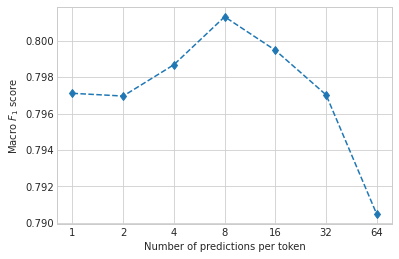

hubert by_f_score


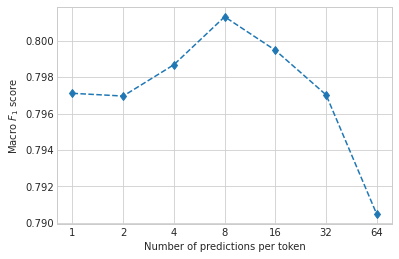

bert-base-multilingual-cased by_loss


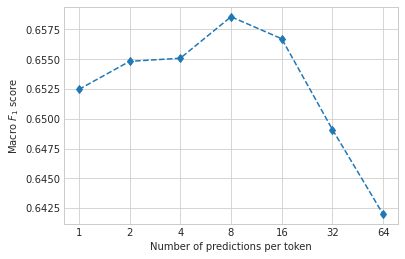

bert-base-multilingual-cased by_f_score


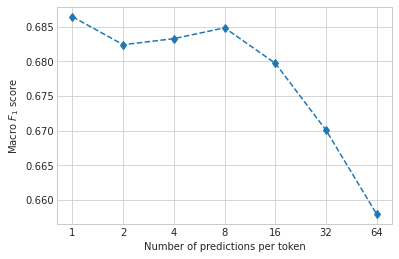

bert-base-multilingual-uncased by_loss


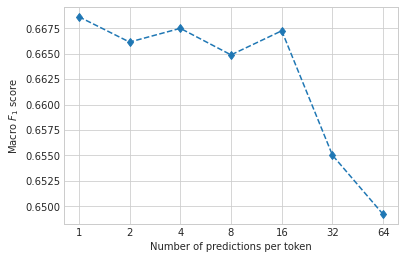

bert-base-multilingual-uncased by_f_score


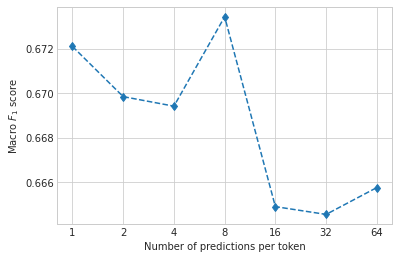

In [41]:
for (model_name, model_type), f_scores in scores.items():
    print(model_name, model_type)
    plt.style.use('seaborn-whitegrid')
    # plt.title('Multiple predictions')
    plt.ylabel('Macro $F_1$ score')
    plt.xlabel('Number of predictions per token')
    plt.xticks(np.arange(int(np.log2(64))+1), [str(2**i) for i in range(0, int(np.log2(64))+1)])
    plt.plot(f_scores[::-1], '--d')
    plt.savefig(f'imgs/valid_multiple_predictions/{model_name}_{model_type}.pdf')
    plt.show()